## Spatial multi-criteria analysis for the strategic spatial placement of blue-green infrastructure

The goal of this jupyter notebook is to handle the analysis and data (pre)processing of 

In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
gdf = gpd.read_file(
    filename="./Data/ribu_wur_soildata.gpkg"
)

gdf.dropna(subset='lutumgehalte', inplace=True)

gdf.head()

,datum,boorpunt_ID,BOVENKANT,ONDERKANT,analysemonster_ID,lutumgehalte,organisch_stofgehalte,geometry
0,NaT,8757,1.0,2.0,6009,2.0,NaN,POINT (121458 483788)
4,NaT,12088,0.1,0.5,8616,1.0,0.8,POINT (121641 483535)
5,NaT,12090,0.5,1.5,8617,0.1,0.6,POINT (121647 483551)
6,NaT,12091,0.5,1.5,8618,0.1,0.4,POINT (121634 483498)
7,NaT,13191,0.3,1.0,9537,12.0,1.6,POINT (122053 484452)


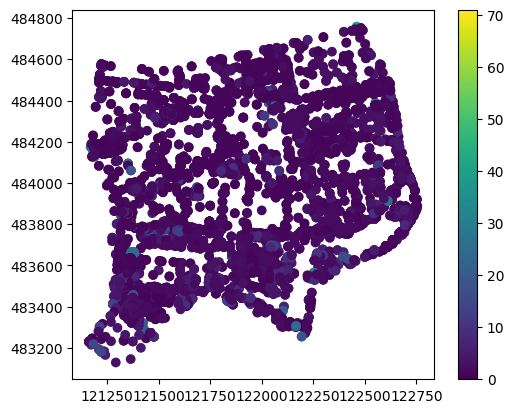

In [3]:
import matplotlib.pyplot as plt

gdf.plot(column='lutumgehalte', legend=True)
plt.show()

<Axes: >

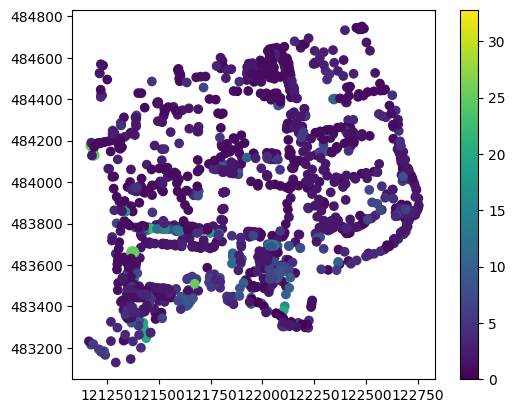

In [4]:
# Select topsoil samples where BOVENKANT is below 0.2 and ONDERKANT is between 0.2 and 0.5
topsoil_samples = gdf[(gdf['BOVENKANT'] < 0.2) & (gdf['ONDERKANT'].between(0.2, 0.5))]

topsoil_samples.plot(column='lutumgehalte', legend=True)

<Axes: >

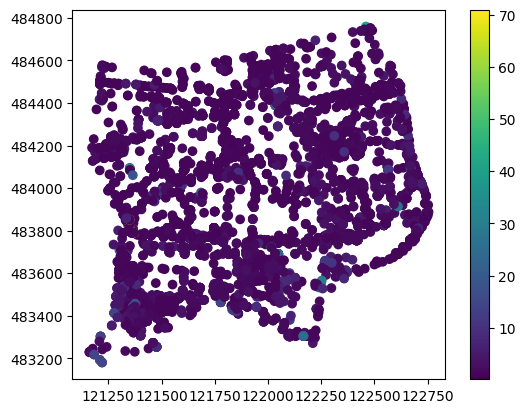

In [5]:
# Select subsoil samples where BOVENKANT is above 0.2 and ONDERKANT is above 0.5
subsoil_samples = gdf[(gdf['BOVENKANT'] > 0.2) & (gdf['ONDERKANT'] > 0.5)]
subsoil_samples.plot(column='lutumgehalte', legend=True)

In [ ]:
# https://geostat-framework.readthedocs.io/projects/gstools/en/stable/examples/08_geo_coordinates/01_dwd_krige.html
# Perform a kriging interpolation on the lutumgehalte values of the topsoil samples
import pykrige
from pykrige.ok import UniversalKriging

# Prepare data for kriging
